In [ ]:
%pip install mlxtend --upgrade
%pip install shap --upgrade

In [ ]:
import pandas as pd
from datetime import datetime
import seaborn as sns

import re
import numpy as np
from collections import Counter

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.compose import TransformedTargetRegressor

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import joblib

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [215]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/final_combind.csv")
removed_columns = list(filter(lambda c: c.endswith('cash-flow-statement'), df.columns))
# print(removed_columns)
df = df.drop(removed_columns, axis=1)
# df = df.drop(['Unnamed: 0'], axis=1)
# df = df[df['Year']>2019]
df = df.dropna()
print(df.shape)
df.describe()
df

(1464, 106)


,Unnamed: 0,Year,Quarter,Number of Workers,Number of Layoffs,revenue,costOfRevenue,grossProfit,grossProfitRatio,ResearchAndDevelopmentExpenses,...,freeCashFlow,employee_count,percent_layoff,industry_labelled,new_cases,new_cases_smoothed,new_cases_per_million,new_deaths,new_deaths_smoothed,new_deaths_per_million
0,0,2005,4,18,1,1.658000e+09,9.070000e+08,7.510000e+08,0.452955,232000000.0,...,9.300000e+07,21000.0,0.000857,0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,1,2008,4,120,1,1.393000e+09,6.370000e+08,7.560000e+08,0.542714,181000000.0,...,-3.000000e+07,19600.0,0.006122,0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,3,2006,2,61,2,5.975000e+09,3.725000e+09,2.250000e+09,0.376569,0.0,...,6.810000e+08,118033.0,0.000517,2,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,4,2008,3,737,5,6.421000e+09,2.695000e+09,3.726000e+09,0.580283,0.0,...,-1.398000e+09,118033.0,0.006244,2,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
5,5,2008,4,1,1,5.469000e+09,1.803000e+09,3.666000e+09,0.670324,0.0,...,-1.553000e+09,118033.0,0.000008,2,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682,1682,2019,1,49,1,9.462000e+08,4.465000e+08,4.997000e+08,0.528112,0.0,...,-4.600000e+06,4800.0,0.010208,576,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1683,1683,2020,2,461,1,4.906000e+08,3.145000e+08,1.761000e+08,0.358948,0.0,...,1.619000e+08,5100.0,0.090392,576,26741.428571,26039.981154,79.048879,1372.78022,1360.849286,4.058055
1684,1684,2020,2,375,1,1.690300e+08,1.182500e+07,1.572050e+08,0.930042,53969000.0,...,6.512000e+06,3900.0,0.096154,577,26741.428571,26039.981154,79.048879,1372.78022,1360.849286,4.058055
1685,1685,2010,1,172,1,8.909600e+07,6.334400e+07,2.575200e+07,0.289037,0.0,...,-1.275700e+07,1130.0,0.152212,578,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [220]:
def forward_elimination_feature_selection(inp_df, num_features):
    input_df = inp_df.drop(columns={'Number of Workers','percent_layoff','Unnamed: 0','Number of Layoffs'})
    X = input_df
    y = inp_df['Number of Workers']

    # Define Sequential Forward Selection (sfs)
    sfs = SFS(
            GradientBoostingRegressor(random_state=42),
            # LinearRegression(),
            k_features=num_features,
            forward=True,
            floating=False,
            scoring = 'r2',
            cv = 4,
            n_jobs=-1)
    
    # Use SFS to select the top k features 
    sfs.fit(X, y)

    # Create a dataframe for the SFS results 
    df_SFS_results = pd.DataFrame(sfs.subsets_).transpose()
    
    # Plot
    fig = plot_sfs(sfs.get_metric_dict(), kind='std_err', figsize=(25,10))
    plt.title('Sequential Forward Selection (w. StdErr)')
    plt.grid()
    plt.show()
    df_SFS_results = df_SFS_results.get(["avg_score","feature_names"]).reset_index().rename(columns={'index': 'label'})
    df_SFS_results['label'] = 'Label_' + df_SFS_results['label'].astype(str)
    return df_SFS_results


In [217]:
y = df['Number of Workers']
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [218]:
print(X_train.shape)
print(X_test.shape)

(1171, 106)
(293, 106)


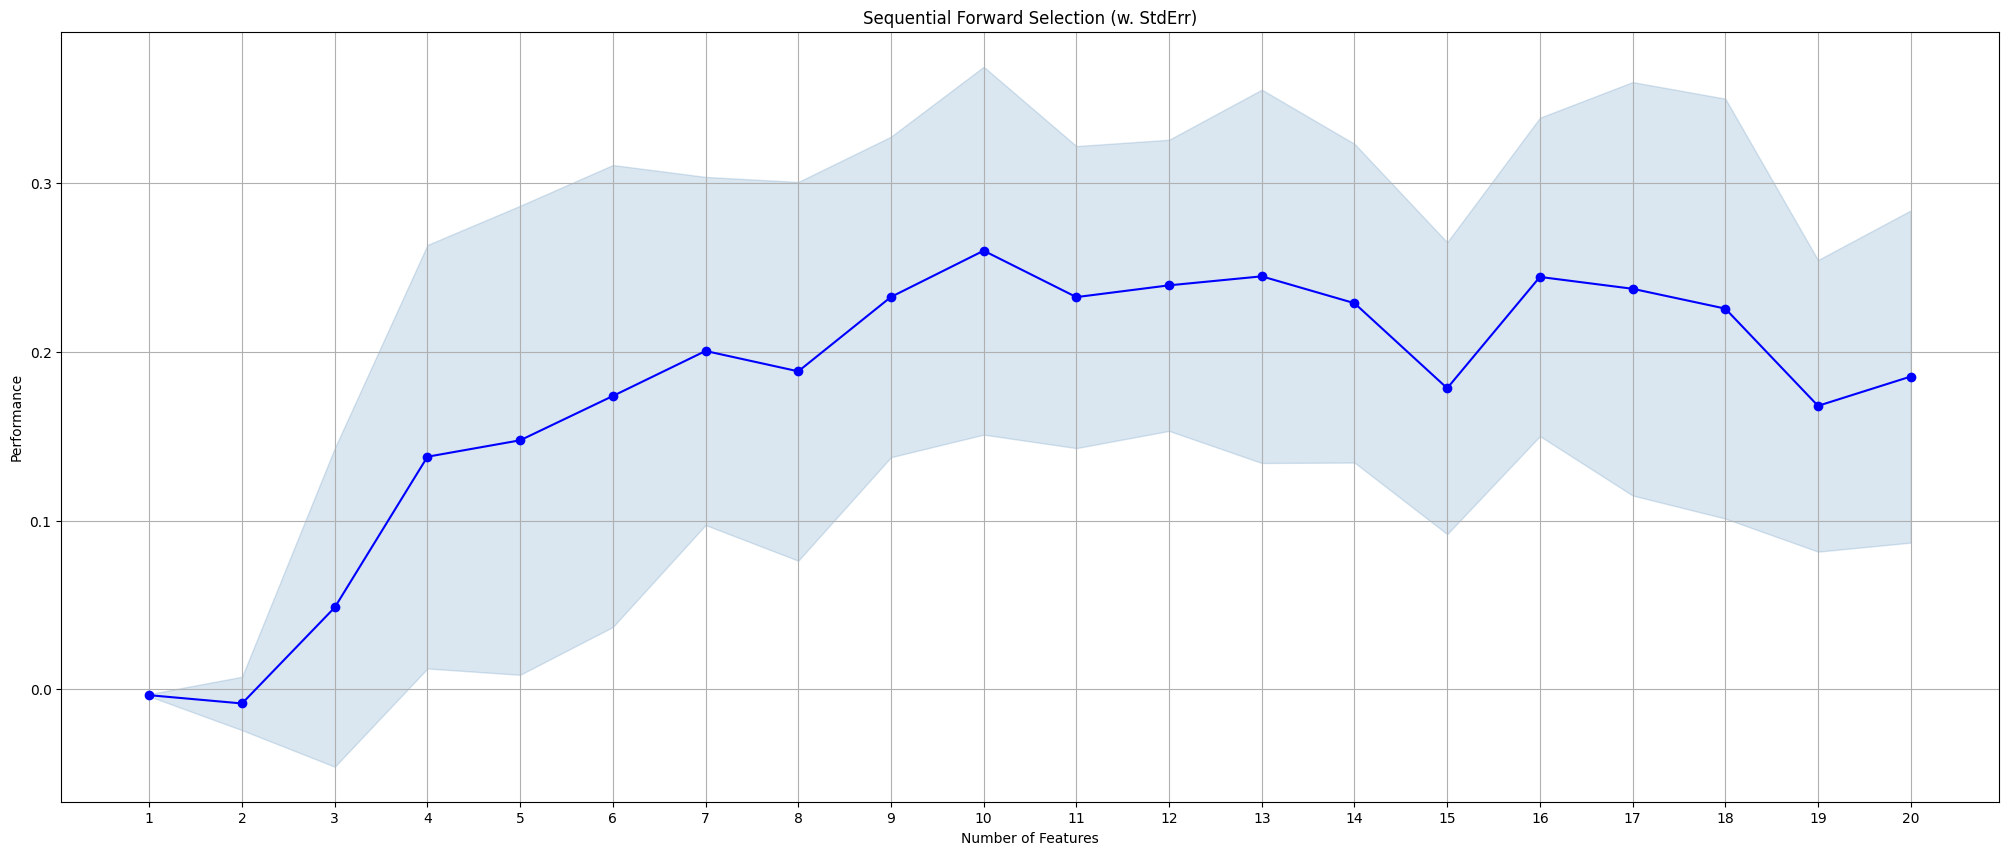

In [222]:
sfs_results = forward_elimination_feature_selection(X_train, 20)

In [223]:
sfs_results['feature_names'].values[-1]

('Year',
 'costAndExpenses',
 'interestExpense',
 'depreciationAndAmortization',
 'EBITDA',
 'netIncome',
 'goodwill',
 'goodwillAndIntangibleAssets',
 'otherAssets',
 'totalAssets',
 'totalNonCurrentLiabilities',
 'otherLiabilities',
 'totalDebt',
 'netDebt',
 'otherNonCashItems',
 'otherInvestingActivites',
 'debtRepayment',
 'commonStockRepurchased',
 'dividendsPaid',
 'netCashUsedProvidedByFinancingActivities')

In [224]:
# features = ['depreciationAndAmortization', 'operatingIncomeRatio', 'totalOtherIncomeExpensesNet', 'incomeBeforeTax', 'goodwill', 'goodwillAndIntangibleAssets', 'longTermDebt', 'accumulatedOtherComprehensiveIncomeLoss', 'otherWorkingCapital', 'acquisitionsNet', 'salesMaturitiesOfInvestments', 'debtRepayment', 'effectOfForexChangesOnCash', 'capitalExpenditure', 'employee_count']
# features = ['grossProfit', 'weightedAverageShsOutDil', 'otherCurrentAssets', 'intangibleAssets', 'goodwillAndIntangibleAssets', 'longTermInvestments', 'totalNonCurrentLiabilities', 'netDebt', 'inventory_cash-flow-statement', 'employee_count']
# features = ['costAndExpenses', 'EBITDA', 'incomeTaxExpense', 'netReceivables', 'propertyPlantEquipmentNet', 'totalAssets', 'deferrredTaxLiabilitiesNonCurrent', 'netIncome_cash-flow-statement', 'otherFinancingActivites', 'netCashUsedProvidedByFinancingActivities']
# features = ['EBITDA', 'totalOtherIncomeExpensesNet', 'netIncome', 'propertyPlantEquipmentNet', 'goodwillAndIntangibleAssets', 'totalAssets', 'totalNonCurrentLiabilities', 'netDebt', 'netIncome_cash-flow-statement', 'depreciationAndAmortization_cash-flow-statement']
features = ['Year',
 'costAndExpenses',
 'interestExpense',
 'depreciationAndAmortization',
 'EBITDA',
 'netIncome',
 'goodwill',
 'goodwillAndIntangibleAssets',
 'otherAssets',
 'totalAssets',
 'totalNonCurrentLiabilities',
 'otherLiabilities',
 'totalDebt',
 'netDebt',
 'otherNonCashItems',
 'otherInvestingActivites',
 'debtRepayment',
 'commonStockRepurchased',
 'dividendsPaid',
 'netCashUsedProvidedByFinancingActivities']
X_train = X_train[features]
X_test = X_test[features]
# y = df['Number of Workers']

In [225]:
def do_regression_grid_search(X_train, X_test, y_train, y_test, model, param_grid, scoring, refit):
    # X_train, X_test, y_train, y_test = \
    #     train_test_split(X, y, test_size=0.2)
    wrapped_model = TransformedTargetRegressor(regressor=model, transformer=StandardScaler())

    gs = GridSearchCV(
        wrapped_model,
        param_grid=param_grid,
        scoring=scoring,
        refit=refit,
        n_jobs=-1,
        return_train_score=True,
        cv=5
    )
    gs.fit(X_train, y_train)

    y_test_hat = gs.predict(X_test)
    # The mean squared error
    print("MSE: %.2f" % mean_squared_error(y_test, y_test_hat))
    # The coefficient of determination: 1 is perfect prediction
    print("R2: %.2f" % r2_score(y_test, y_test_hat))
    print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, y_test_hat))
    return gs.best_estimator_

In [195]:
def save_model(model, path):
    joblib.dump(model, path)

In [196]:
def load_model(path):
    return joblib.load(path)

In [197]:
scoring = {"mse": make_scorer(mean_squared_error, greater_is_better=False), "r2": make_scorer(r2_score)}
refit = "r2"

In [226]:
dtree_regr = DecisionTreeRegressor(random_state=42)

param_grid = {
    "regressor__regressor__min_samples_split": range(2, 101, 20),
    "regressor__regressor__max_depth": [5, 10, 15],
}

dtree_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', dtree_regr)
])

dtree_model = do_regression_grid_search(X_train, X_test, y_train, y_test, dtree_pipeline, param_grid=param_grid, scoring=scoring, refit=refit)
save_model(dtree_model, "/content/drive/MyDrive/Colab Notebooks/dtree_regr_1.sav")

MSE: 833932.37
R2: 0.15
MAPE: 6.00


In [228]:
rf_regr = RandomForestRegressor(random_state=42)

param_grid = {
    "regressor__regressor__n_estimators": range(2, 101, 20),
    "regressor__regressor__max_depth": [5, 10, 15],
}

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', rf_regr)
])

rf_model=do_regression_grid_search(X_train, X_test, y_train, y_test, rf_pipeline, param_grid=param_grid, scoring=scoring, refit=refit)
save_model(rf_model, "/content/drive/MyDrive/Colab Notebooks/rf_regr_1.sav")

MSE: 352420.31
R2: 0.64
MAPE: 6.34


In [235]:
gbt_regr = GradientBoostingRegressor(random_state=42)

param_grid = {
    "regressor__regressor__n_estimators": range(2, 101, 20),
    "regressor__regressor__max_depth": [5, 10, 15],
    "regressor__regressor__learning_rate": [0.0001, 0.001, 0.01],
}

gbt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', gbt_regr)
])

gbt_model=do_regression_grid_search(X_train, X_test, y_train, y_test, gbt_pipeline, param_grid=param_grid, scoring=scoring, refit=refit)
save_model(gbt_model, "/content/drive/MyDrive/Colab Notebooks/gbt_regr_1.sav")

MSE: 547148.12
R2: 0.44
MAPE: 6.42


In [229]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [243]:
X_sampled = shap.sample(X_train, 100)
# X_sampled = shap.kmeans(X_train, 10).data

rf_explainer = shap.KernelExplainer(rf_model.predict, X_sampled, keep_index=True)
rf_shap_values = rf_explainer.shap_values(X_sampled)

  0%|          | 0/100 [00:00<?, ?it/s]

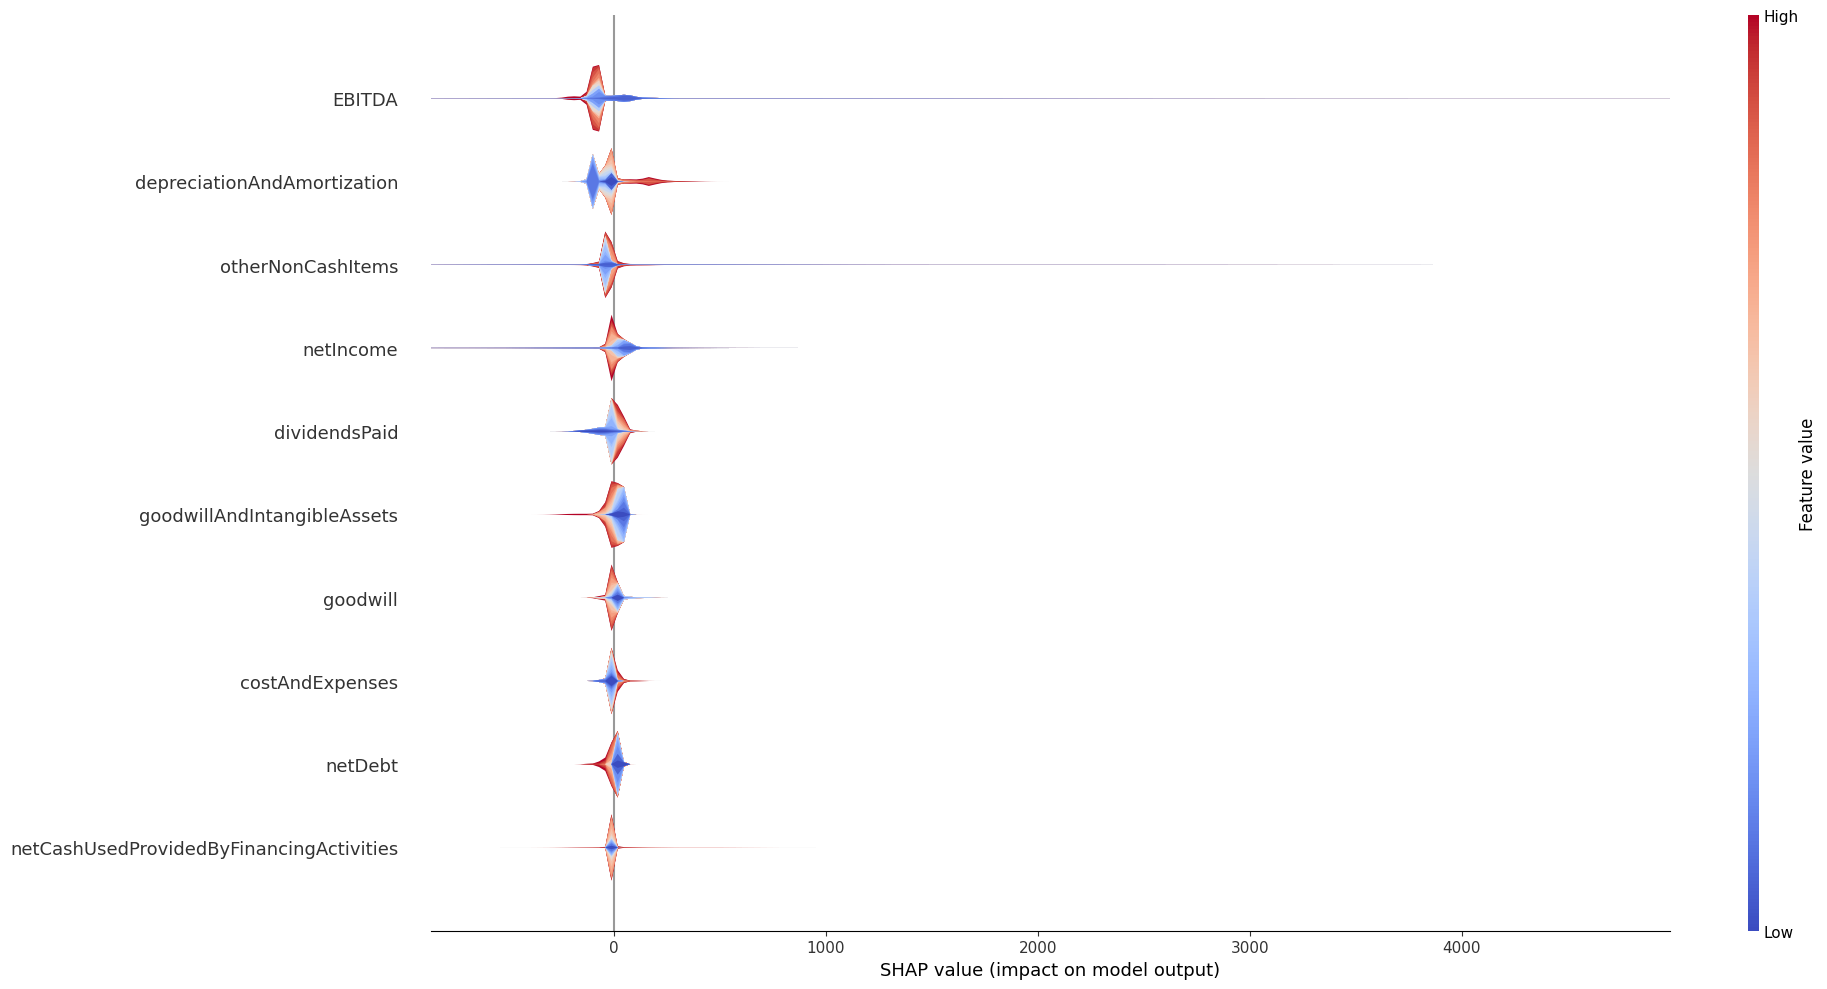

In [244]:
shap.summary_plot(rf_shap_values, X_sampled, plot_type="layered_violin", plot_size=(20, 10), max_display=10, )

In [236]:
gbt_explainer = shap.KernelExplainer(gbt_model.predict, X_sampled, keep_index=True)
gbt_shap_values = gbt_explainer.shap_values(X_sampled)

  0%|          | 0/200 [00:00<?, ?it/s]

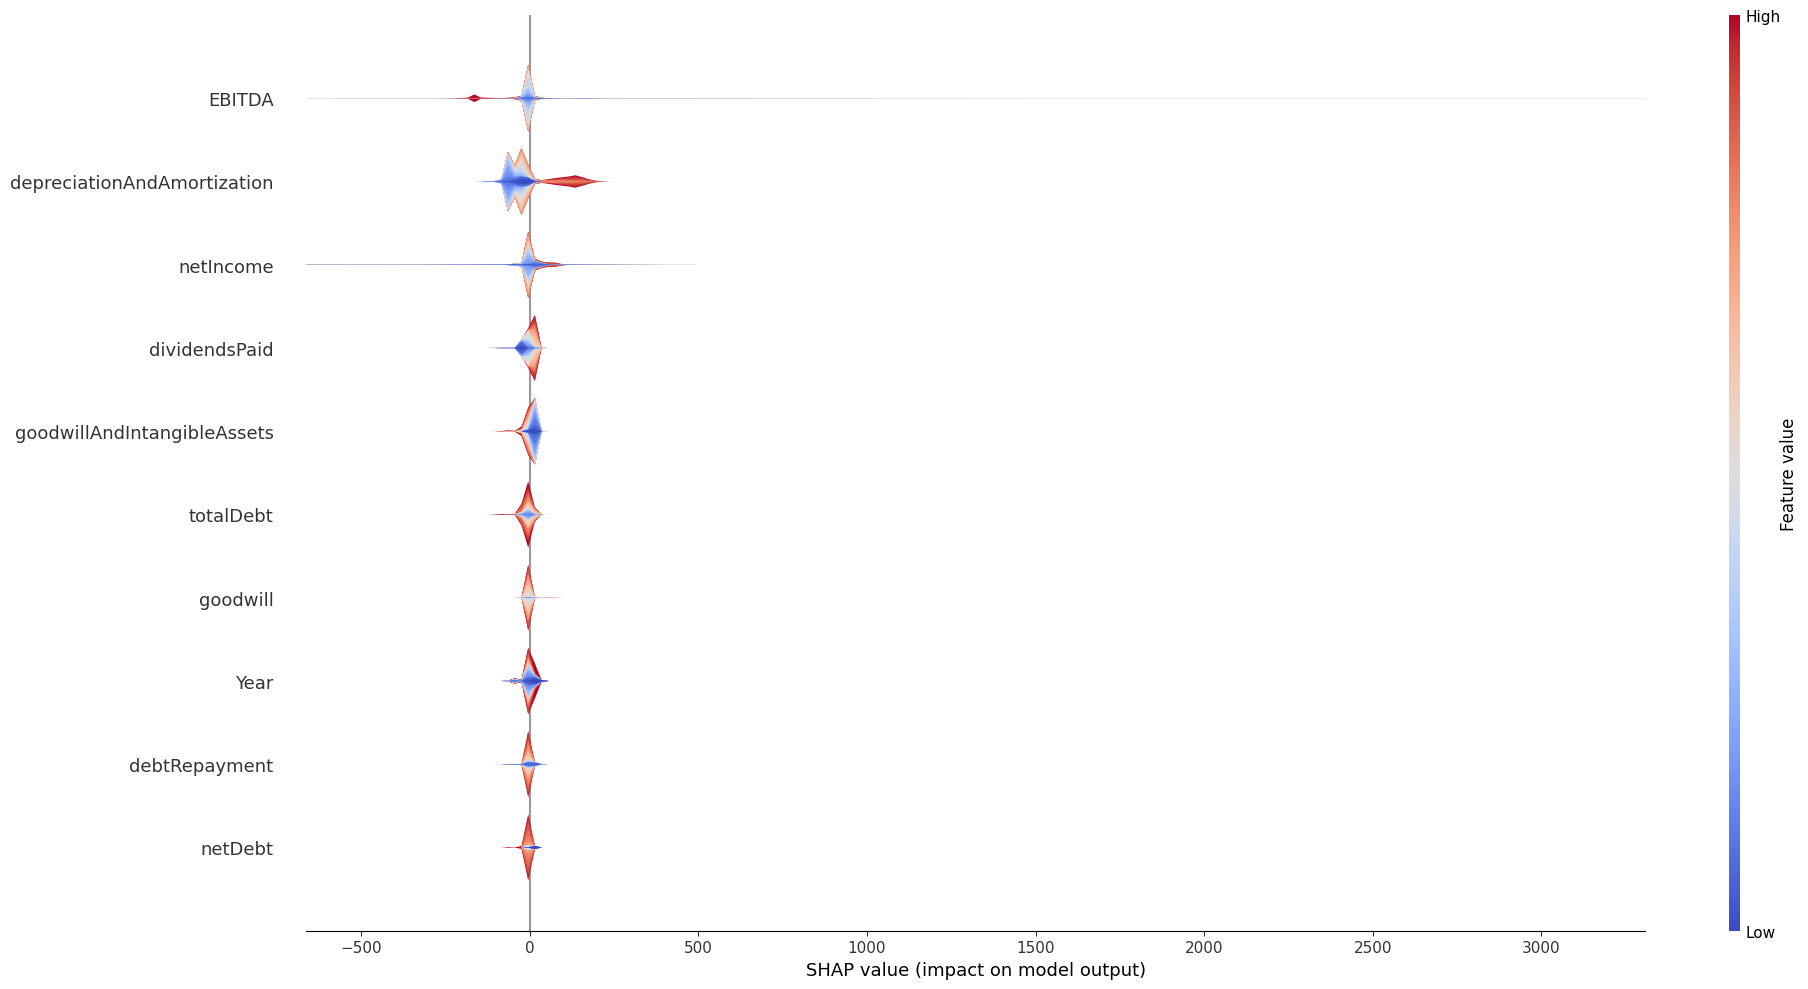

In [240]:
shap.summary_plot(gbt_shap_values, X_sampled, plot_type="layered_violin", plot_size=(20, 10), max_display=10)

In [232]:
shap.force_plot(explainer.expected_value, shap_values, X_sampled)

In [248]:
import xgboost

xgb_regr = xgboost.XGBRegressor()

param_grid = {
    "regressor__regressor__n_estimators": range(2, 1001, 100),
    "regressor__regressor__max_depth": [5, 10, 15],
    "regressor__regressor__learning_rate": [0.0001, 0.001, 0.01],
}

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', xgb_regr)
])

xgb_model=do_regression_grid_search(X_train, X_test, y_train, y_test, xgb_pipeline, param_grid=param_grid, scoring=scoring, refit=refit)
# save_model(gbt_model, "/content/drive/MyDrive/Colab Notebooks/gbt_regr_1.sav")

MSE: 685881.09
R2: 0.30
MAPE: 21.29


In [ ]:
predict_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/final_combined_df.csv')
predict_df_features = predict_df[features]
predicted_results = rf_model.predict(predict_df_features)
predicted_results

array([134.82042751, 134.82042751, 141.83073772, ..., 120.36169577,
       124.86043314, 120.36169577])

In [ ]:
actual_results = predict_df['Number of Workers'].values
actual_results

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
mean_absolute_percentage_error(actual_results, predicted_results)

8.820871732901868e+17